# ArangoDB PyG Adapter Getting Started Guide  

<a href="https://colab.research.google.com/github/arangoml/pyg-adapter/blob/1.1.0/examples/ArangoDB_PyG_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![arangodb](https://raw.githubusercontent.com/arangoml/dgl-adapter/master/examples/assets/adb_logo.png)
<img src="https://raw.githubusercontent.com/pyg-team/pyg_sphinx_theme/master/pyg_sphinx_theme/static/img/pyg_logo_text.svg?sanitize=true" width=40% />

Version: 1.1.2

Objective: Export Graphs from [ArangoDB](https://www.arangodb.com/), the multi-model database for graph & beyond, to [PyTorch Geometric](https://www.pyg.org/) (PyG), a python package for graph neural networks, and vice-versa.

# Setup

In [55]:
%%capture
!pip install torch
!pip install adbpyg-adapter==1.1.2
!pip install adb-cloud-connector
!git clone -b 1.1.2 --single-branch https://github.com/arangoml/pyg-adapter.git

## For drawing purposes 
!pip install matplotlib
!pip install networkx

In [56]:
# All imports

import pandas
import torch
from torch_geometric.data import Data, HeteroData
from torch_geometric.datasets import FakeDataset, FakeHeteroDataset, KarateClub
from torch_geometric.utils import to_networkx
from torch_geometric.typing import EdgeType

from adbpyg_adapter import ADBPyG_Adapter, ADBPyG_Controller
from adbpyg_adapter.encoders import IdentityEncoder, CategoricalEncoder
from adbpyg_adapter.typings import Json, ADBMetagraph, PyGMetagraph

from arango import ArangoClient
from adb_cloud_connector import get_temp_credentials

import json
import logging

import matplotlib.pyplot as plt
import networkx as nx

# Understanding PyG

(referenced from [pytorch-geometric.readthedocs.io](https://pytorch-geometric.readthedocs.io/))


PyG (PyTorch Geometric) is a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data.

At its core, PyG provides the following main features:
1. Data Handling of Graphs
2. Common Benchmark Datasets
3. Mini-batches
4. Data Transforms
5. Learning Methods on Graphs
6. Exercises

PyG represents a graph as an instance of `torch_geometric.data.Data`, which holds the following attributes by default:

* `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`
* `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`
* `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`
* `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:


In [57]:
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


Besides holding a number of node-level, edge-level or graph-level attributes, Data provides a number of useful utility functions, e.g.:

In [58]:
print(data.keys)

print(data['x'])


for key, item in data:
    print(f'{key} found in data')

print('edge_attr' in data)
print(data.num_nodes)
print(data.num_edges)
print(data.num_node_features)
print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_directed())

# Transfer data object to GPU (requires Tesla T4 GPU if running in Colab)
# device = torch.device('cuda')
# data = data.to(device)

['x', 'edge_index']
tensor([[-1.],
        [ 0.],
        [ 1.]])
x found in data
edge_index found in data
False
3
4
1
False
False
False


PyG also supports Heterogeneous graphs:

In [59]:
data = HeteroData()

data["user"].x = torch.tensor([[21], [16], [38], [64]])
data[("user", "follows", "user")].edge_index = torch.tensor([[0, 1], [1, 2]])
data[("user", "follows", "game")].edge_index = torch.tensor([[0, 1, 2], [0, 1, 2]])
data[("user", "plays", "game")].edge_index = torch.tensor([[3, 3], [1, 2]])
data[("user", "plays", "game")].edge_attr = torch.tensor([[3], [5]])

print(data)
print(data.node_types)
print(data.edge_types)

HeteroData(
  user={ x=[4, 1] },
  (user, follows, user)={ edge_index=[2, 2] },
  (user, follows, game)={ edge_index=[2, 3] },
  (user, plays, game)={
    edge_index=[2, 2],
    edge_attr=[2, 1]
  }
)
['user']
[('user', 'follows', 'user'), ('user', 'follows', 'game'), ('user', 'plays', 'game')]


For more info, visit [pytorch-geometric.readthedocs.io](https://pytorch-geometric.readthedocs.io/). 

# Create a Temporary ArangoDB Cloud Instance

In [60]:
# Request temporary instance from the managed ArangoDB Cloud Service.
con = get_temp_credentials()
print(json.dumps(con, indent=2))

# Connect to the db via the python-arango driver
db = ArangoClient(hosts=con["url"]).db(con["dbName"], con["username"], con["password"], verify=True)

Success: reusing cached credentials
{
  "dbName": "TUT6uidw6608c3fel9fgotpk5",
  "username": "TUTctbabijgogsqfi4r0hj59",
  "password": "TUTkpfg3sjmx88qu3aoi90ucs",
  "hostname": "tutorials.arangodb.cloud",
  "port": 8529,
  "url": "https://tutorials.arangodb.cloud:8529"
}


Feel free to use to above URL to checkout the UI!

# Data Import

For demo purposes, we will be using the [ArangoDB IMDB example graph](https://www.arangodb.com/docs/stable/arangosearch-example-datasets.html#imdb-movie-dataset).

In [61]:
!chmod -R 755 pyg-adapter/
!./pyg-adapter/tests/tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --replication-factor 3  --input-directory "pyg-adapter/tests/data/adb/imdb_dump" --include-system-collections true

2022-08-05T20:42:33Z [1529] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://tutorials.arangodb.cloud:8529'
2022-08-05T20:42:34Z [1529] INFO [abeb4] {restore} Database name in source dump is 'TUTdit9ohpgz1ntnbetsjstwi'
2022-08-05T20:42:34Z [1529] INFO [9b414] {restore} # Re-creating document collection 'Movies'...
2022-08-05T20:42:39Z [1529] INFO [9b414] {restore} # Re-creating document collection 'Users'...
2022-08-05T20:42:40Z [1529] INFO [9b414] {restore} # Re-creating edge collection 'Ratings'...
2022-08-05T20:42:40Z [1529] INFO [6d69f] {restore} # Dispatched 3 job(s), using 2 worker(s)
2022-08-05T20:42:40Z [1529] INFO [94913] {restore} # Loading data into document collection 'Movies', data size: 68107 byte(s)
2022-08-05T20:42:40Z [1529] INFO [94913] {restore} # Loading data into document collection 'Users', data size: 16717 byte(s)
2022-08-05T20:42:40Z [1529] INFO [6ae09] {restore} # Successfully restored document collection 'Users'
2022-08-05T20:42:40Z [1529] INFO [94913]

In [62]:
# Create the IMDB graph
db.delete_graph("imdb", ignore_missing=True)
db.create_graph(
    "imdb",
    edge_definitions=[
        {
            "edge_collection": "Ratings",
            "from_vertex_collections": ["Users"],
            "to_vertex_collections": ["Movies"],
        },
    ],
)

<Graph imdb>

# Instantiate the Adapter

Connect the ArangoDB-PyG Adapter to our temporary ArangoDB cluster:

In [63]:
adbpyg_adapter = ADBPyG_Adapter(db)

[2022/08/05 20:42:49 +0000] [58] [INFO] - adbpyg_adapter: Instantiated ADBPyG_Adapter with database 'TUT6uidw6608c3fel9fgotpk5'
INFO:adbpyg_adapter:Instantiated ADBPyG_Adapter with database 'TUT6uidw6608c3fel9fgotpk5'


# <u>PyG to ArangoDB</u>

#### Karate Graph

Data
* [PyG Karate Graph](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub)

API
* `adbpyg_adapter.adapter.pyg_to_arangodb()`

Notes
* The `name` parameter is used to name your ArangoDB graph.

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


Output()

Output()

[2022/08/05 20:42:51 +0000] [58] [INFO] - adbpyg_adapter: Created ArangoDB 'Karate' Graph
INFO:adbpyg_adapter:Created ArangoDB 'Karate' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUTctbabijgogsqfi4r0hj59
Password: TUTkpfg3sjmx88qu3aoi90ucs
Database: TUT6uidw6608c3fel9fgotpk5
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUT6uidw6608c3fel9fgotpk5/_admin/aardvark/index.html#graph/Karate

View the original graph below:



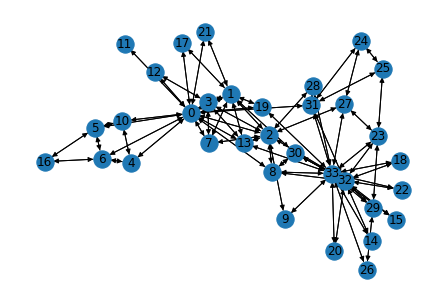

In [64]:
# Create the PyG graph & draw it
pyg_karate_graph = KarateClub()[0]
print(pyg_karate_graph)
nx.draw(to_networkx(pyg_karate_graph), with_labels=True)

name = "Karate"

# Delete the graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graph
adb_karate_graph = adbpyg_adapter.pyg_to_arangodb(name, pyg_karate_graph)

# You can also provide valid Python-Arango Import Bulk options to the command above, like such:
# adb_karate_graph = adbpyg_adapter.pyg_to_arangodb(name, pyg_karate_graph, batch_size=5, on_duplicate="replace")
# See the full parameter list at https://docs.python-arango.com/en/main/specs.html#arango.collection.Collection.import_bulk

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")


#### FakeHomogeneous Graph

Data
* [PyG FakeDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.FakeDataset)

API
*  `adbpyg_adapter.adapter.pyg_to_arangodb()`

Notes
* The `name` parameter is used to name your ArangoDB graph.

Data(y=[36], edge_index=[2, 556], x=[36, 64], edge_weight=[556])


Output()

Output()

[2022/08/05 20:42:54 +0000] [58] [INFO] - adbpyg_adapter: Created ArangoDB 'FakeHomo' Graph
INFO:adbpyg_adapter:Created ArangoDB 'FakeHomo' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUTctbabijgogsqfi4r0hj59
Password: TUTkpfg3sjmx88qu3aoi90ucs
Database: TUT6uidw6608c3fel9fgotpk5
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUT6uidw6608c3fel9fgotpk5/_admin/aardvark/index.html#graph/FakeHomo

View the original graph below:



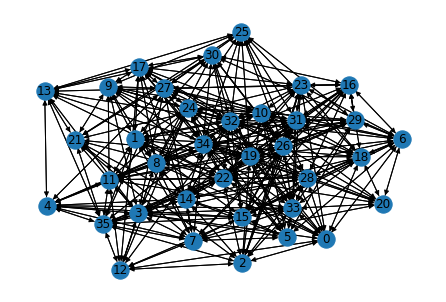

In [65]:
# Create the PyG graph & draw it
pyg_homo_graph = FakeDataset(avg_num_nodes=30, edge_dim=1)[0] # 'edge_weight' property
print(pyg_homo_graph)
nx.draw(to_networkx(pyg_homo_graph), with_labels=True)

name = "FakeHomo"

# Delete the graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graph
adb_homo_graph = adbpyg_adapter.pyg_to_arangodb(name, pyg_homo_graph)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")


#### FakeHeterogeneous Graph

Data
* [PyG FakeHeteroDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.FakeHeteroDataset)

API
*  `adbpyg_adapter.adapter.pyg_to_arangodb()`

Notes
* The `name` parameter is used to name your ArangoDB graph.

In [66]:
# Create the PyG graph
pyg_hetero_graph = FakeHeteroDataset(avg_num_nodes=30, edge_dim=2)[0] # 'edge_attr' property

name = "FakeHetero"

# Delete the graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graphs
adb_hetero_graph = adbpyg_adapter.pyg_to_arangodb(name, pyg_hetero_graph)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:43:03 +0000] [58] [INFO] - adbpyg_adapter: Created ArangoDB 'FakeHetero' Graph
INFO:adbpyg_adapter:Created ArangoDB 'FakeHetero' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUTctbabijgogsqfi4r0hj59
Password: TUTkpfg3sjmx88qu3aoi90ucs
Database: TUT6uidw6608c3fel9fgotpk5
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUT6uidw6608c3fel9fgotpk5/_admin/aardvark/index.html#graph/FakeHetero

View the original graph below:




#### FakeHeterogeneous Graph with a PyG-ArangoDB metagraph

Data
* [PyG FakeHeteroDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.FakeHeteroDataset)

API
*  `adbpyg_adapter.adapter.pyg_to_arangodb()`

Notes
* The `name` parameter is used to name your ArangoDB graph.
* The `metagraph` parameter is an optional object mapping the PyG keys of the node & edge data to  strings, list of strings, or user-defined functions.

HeteroData(
  v0={
    x=[15, 2],
    y=[15]
  },
  v1={ x=[19, 2] },
  (v1, e0, v0)={
    edge_index=[2, 142],
    edge_attr=[142, 2]
  },
  (v0, e0, v1)={
    edge_index=[2, 115],
    edge_attr=[115, 2]
  },
  (v0, e0, v0)={
    edge_index=[2, 115],
    edge_attr=[115, 2]
  }
)


Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:43:07 +0000] [58] [INFO] - adbpyg_adapter: Created ArangoDB 'FakeHetero' Graph
INFO:adbpyg_adapter:Created ArangoDB 'FakeHetero' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUTctbabijgogsqfi4r0hj59
Password: TUTkpfg3sjmx88qu3aoi90ucs
Database: TUT6uidw6608c3fel9fgotpk5
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUT6uidw6608c3fel9fgotpk5/_admin/aardvark/index.html#graph/FakeHetero

View the original graph below:



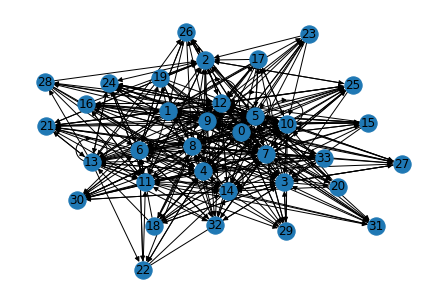

In [67]:
# Create the PyG graph
pyg_hetero_graph = FakeHeteroDataset(
    num_node_types=2,
    num_edge_types=3,
    avg_num_nodes=20,
    avg_num_channels=3,  # avg number of features per node
    edge_dim=2,  # number of features per edge
    num_classes=3,  # number of unique label values
)[0]
print(pyg_hetero_graph)
nx.draw(to_networkx(pyg_hetero_graph.to_homogeneous()), with_labels=True)

# Define the metagraph
def y_tensor_to_2_column_dataframe(pyg_tensor):
    label_map = {0: "Kiwi", 1: "Blueberry", 2: "Avocado"}

    df = pandas.DataFrame(columns=["label_num", "label_str"])
    df["label_num"] = pyg_tensor.tolist()
    df["label_str"] = df["label_num"].map(label_map)

    return df

metagraph = {
    "nodeTypes": {
        "v0": {
            "x": "features",  # 1) You can specify a string value if you want to rename your PyG data when stored in ArangoDB
            "y": y_tensor_to_2_column_dataframe,  # 2) you can specify a function for user-defined handling, as long as the function returns a Pandas DataFrame
        },
        # 3) You can specify set of strings if you want to preserve the same PyG attribute names for the node/edge type
        "v1": {"x"} # this is equivalent to {"x": "x"}
    },
    "edgeTypes": {
        ("v0", "e0", "v0"): {
            # 4) You can specify a list of strings for tensor dissasembly (if you know the number of node/edge features in advance)
            "edge_attr": [ "a", "b"]  
        },
    },
}

name = "FakeHetero"

db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graph with `explicit_metagraph=False`
adb_hetero_graph = adbpyg_adapter.pyg_to_arangodb(name, pyg_hetero_graph, metagraph, explicit_metagraph=False)

# Create the ArangoDB graph with `explicit_metagraph=True`
# With `explicit_metagraph=True`, the node & edge types omitted from the metagraph will NOT be converted to ArangoDB.
# Only 'v0' and ('v0', 'e0', 'v0') will be brought over (i.e 'v1', ('v0', 'e0', 'v1'), ... are ignored):
## adb_hetero_graph_explicit = adbpyg_adapter.pyg_to_arangodb(name, pyg_hetero_graph, metagraph, explicit_metagraph=True)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")


#### FakeHeterogeneous Graph with a user-defined ADBPyG Controller

Data
* [PyG FakeHeteroDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.FakeHeteroDataset)

API
*  `adbpyg_adapter.adapter.pyg_to_arangodb()`

Notes
* The `name` parameter is used to name your ArangoDB graph.
* The `ADBPyG_Controller` is an optional user-defined class for controlling how nodes & edges are handled when transitioning from PyG to ArangoDB. **It is interpreted as the alternative to the `metagraph` parameter.**

In [68]:
# Create the PyG graph
pyg_hetero_graph = FakeHeteroDataset(avg_num_nodes=30, edge_dim=2)[0] # 'edge_attr' property

name = "FakeHetero"

db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create a custom ADBPyG_Controller
class Custom_ADBPyG_Controller(ADBPyG_Controller):
    """ArangoDB-PyG controller.

    Responsible for controlling how nodes & edges are handled when
    transitioning from PyG to ArangoDB.

    You can derive your own custom ADBPyG_Controller.
    """

    def _prepare_pyg_node(self, pyg_node: dict, col: str) -> dict:
        """Optionally modify a PyG node object before it gets inserted into its designated ArangoDB collection.

        :param pyg_node: The PyG node object to (optionally) modify.
        :param col: The ArangoDB collection the PyG node belongs to.
        :return: The PyG Node object
        """
        pyg_node["foo"] = "bar"
        return pyg_node

    def _prepare_pyg_edge(self, pyg_edge: dict, edge_type: tuple) -> dict:
        """Optionally modify a PyG edge object before it gets inserted into its designated ArangoDB collection.

        :param pyg_edge: The PyG edge object to (optionally) modify.
        :param edge_type: The Edge Type of the PyG edge. Formatted
            as (from_collection, edge_collection, to_collection)
        :return: The PyG Edge object
        """
        pyg_edge["bar"] = "foo"
        return pyg_edge

# Instantiate new adapter & create the ArangoDB graph
adb_hetero_graph = ADBPyG_Adapter(db, Custom_ADBPyG_Controller()).pyg_to_arangodb(name, pyg_hetero_graph)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")

[2022/08/05 20:43:12 +0000] [58] [INFO] - adbpyg_adapter: Instantiated ADBPyG_Adapter with database 'TUT6uidw6608c3fel9fgotpk5'
INFO:adbpyg_adapter:Instantiated ADBPyG_Adapter with database 'TUT6uidw6608c3fel9fgotpk5'


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:43:19 +0000] [58] [INFO] - adbpyg_adapter: Created ArangoDB 'FakeHetero' Graph
INFO:adbpyg_adapter:Created ArangoDB 'FakeHetero' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUTctbabijgogsqfi4r0hj59
Password: TUTkpfg3sjmx88qu3aoi90ucs
Database: TUT6uidw6608c3fel9fgotpk5
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUT6uidw6608c3fel9fgotpk5/_admin/aardvark/index.html#graph/FakeHetero



# <u>ArangoDB to PyG</u>



In [69]:
# Start from scratch! (with a smaller graph)
data = FakeHeteroDataset(
    num_node_types=2,
    num_edge_types=3,
    avg_num_nodes=20,
    avg_num_channels=3,  # avg number of features per node
    edge_dim=2,  # number of features per edge
    num_classes=3,  # number of unique label values
)[0]

db.delete_graph("FakeHetero", drop_collections=True, ignore_missing=True)
adbpyg_adapter.pyg_to_arangodb("FakeHetero", data)

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:43:21 +0000] [58] [INFO] - adbpyg_adapter: Created ArangoDB 'FakeHetero' Graph
INFO:adbpyg_adapter:Created ArangoDB 'FakeHetero' Graph


<Graph FakeHetero>

#### Via ArangoDB Graph

Data
* [PyG FakeHeteroDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.FakeHeteroDataset)

API
* `adbpyg_adapter.adapter.arangodb_graph_to_pyg()`

Notes
* The `name` parameter in this case must point to an existing ArangoDB graph in your ArangoDB instance.
* Due to risk of ambiguity, this method does **not** carry over ArangoDB attributes to PyG.

In [70]:
# Define graph name
graph_name = "FakeHetero"

# Create PyG graph from the ArangoDB graph
pyg_hetero_graph = adbpyg_adapter.arangodb_graph_to_pyg(graph_name)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# pyg_hetero_graph = adbpyg_adapter.arangodb_graph_to_pyg(graph_name, ttl=1000, stream=True)
# See the full parameter list at https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(pyg_hetero_graph)

Output()

Output()

Output()

[2022/08/05 20:43:22 +0000] [58] [INFO] - adbpyg_adapter: Created PyG 'FakeHetero' Graph
INFO:adbpyg_adapter:Created PyG 'FakeHetero' Graph



--------------------
HeteroData(
  v0={},
  v1={},
  (v0, e0, v1)={ edge_index=[2, 167] },
  (v1, e0, v0)={ edge_index=[2, 139] },
  (v1, e0, v1)={ edge_index=[2, 128] }
)


#### Via ArangoDB Collections

Data
* [PyG FakeHeteroDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.FakeHeteroDataset)

API
* `adbpyg_adapter.adapter.arangodb_collections_to_pyg()`

Notes
* The `name` parameter is purely for documentation purposes in this case.
* The `vertex_collections` & `edge_collections` parameters must point to existing ArangoDB collections within your ArangoDB instance.
* Due to risk of ambiguity, this method does **not** carry over ArangoDB attributes to PyG.

In [71]:
# Define collection names
v_cols = {"v0", "v1"}
e_cols = {"e0"}

# Create PyG graph from the ArangoDB collections
pyg_hetero_graph = adbpyg_adapter.arangodb_collections_to_pyg("FakeHetero", v_cols, e_cols)

# Show graph data
print('\n--------------------')
print(pyg_hetero_graph)

Output()

Output()

Output()

[2022/08/05 20:43:23 +0000] [58] [INFO] - adbpyg_adapter: Created PyG 'FakeHetero' Graph
INFO:adbpyg_adapter:Created PyG 'FakeHetero' Graph



--------------------
HeteroData(
  v0={},
  v1={},
  (v0, e0, v1)={ edge_index=[2, 167] },
  (v1, e0, v0)={ edge_index=[2, 139] },
  (v1, e0, v1)={ edge_index=[2, 128] }
)


#### Via ArangoDB-PyG metagraph 1

Data
* [PyG FakeHeteroDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.FakeHeteroDataset)

API
* `adbpyg_adapter.adapter.arangodb_to_pyg()`

Notes
* The `name` parameter is purely for documentation purposes in this case.
* The `metagraph` parameter is an object defining vertex & edge collections to import to PyG, along with collection-level specifications to indicate which ArangoDB attributes will become PyG features/labels. It should contain collections & associated document attributes names that exist within your ArangoDB instance.

In [72]:
# Define the Metagraph that transfers ArangoDB attributes "as is",
# meaning the data is already formatted to PyG data standards
metagraph_v1 = {
    "vertexCollections": {
        # Move the "x" & "y" ArangoDB attributes to PyG as "x" & "y" Tensors
        "v0": {"x", "y"}, # equivalent to {"x": "x", "y": "y"}
        "v1": {"v1_x": "x"},
    },
    "edgeCollections": {
        "e0": {"edge_attr"},
    },
}

# Create PyG Graph
pyg_hetero_graph = adbpyg_adapter.arangodb_to_pyg("FakeHetero", metagraph_v1)

# Show graph data
print('\n--------------------')
print(pyg_hetero_graph)

Output()

Output()

Output()

[2022/08/05 20:43:23 +0000] [58] [INFO] - adbpyg_adapter: Created PyG 'FakeHetero' Graph
INFO:adbpyg_adapter:Created PyG 'FakeHetero' Graph



--------------------
HeteroData(
  v0={
    x=[21, 3],
    y=[21]
  },
  v1={ v1_x=[17, 2] },
  (v0, e0, v1)={
    edge_index=[2, 167],
    edge_attr=[167, 2]
  },
  (v1, e0, v0)={
    edge_index=[2, 139],
    edge_attr=[139, 2]
  },
  (v1, e0, v1)={
    edge_index=[2, 128],
    edge_attr=[128, 2]
  }
)


#### Via ArangoDB-PyG metagraph 2

Data
* [ArangoDB IMDB Movie Dataset](https://www.arangodb.com/docs/stable/arangosearch-example-datasets.html#imdb-movie-dataset)

API
* `adbpyg_adapter.adapter.arangodb_to_pyg()`

Notes
* The `name` parameter is purely for documentation purposes in this case.
* The `metagraph` parameter is an object defining vertex & edge collections to import to PyG, along with collection-level specifications to indicate which ArangoDB attributes will become PyG features/labels. In this example, we rely on user-defined encoders to build PyG-ready tensors (i.e feature matrices) from ArangoDB attributes. See https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html for an example on using encoders with PyG.

In [73]:
# Define the Metagraph that transfers attributes via user-defined encoders
metagraph_v2 = {
    "vertexCollections": {
        "Movies": {
            "x": {  # Build a feature matrix from the "Action" & "Drama" document attributes
                "Action": IdentityEncoder(dtype=torch.long),
                "Drama": IdentityEncoder(dtype=torch.long),
            },
            "y": "Comedy",
        },
        "Users": {
            "x": {
                "Gender": CategoricalEncoder(), # CategoricalEncoder(mapping={"M": 0, "F": 1}),
                "Age": IdentityEncoder(dtype=torch.long),
            }
        },
    },
    "edgeCollections": {
        "Ratings": {
            "edge_weight": "Rating"
        }
    },
}

# Create PyG Graph
pyg_imdb_graph = adbpyg_adapter.arangodb_to_pyg("IMDB", metagraph_v2)

# Show graph data
print('\n--------------------')
print(pyg_imdb_graph)

Output()

Output()

Output()

[2022/08/05 20:43:35 +0000] [58] [INFO] - adbpyg_adapter: Created PyG 'IMDB' Graph
INFO:adbpyg_adapter:Created PyG 'IMDB' Graph



--------------------
HeteroData(
  Movies={
    x=[1682, 2],
    y=[1682]
  },
  Users={ x=[943, 2] },
  (Users, Ratings, Movies)={
    edge_index=[2, 65499],
    edge_weight=[65499]
  }
)


#### Via ArangoDB-PyG metagraph 3

Data
* [PyG FakeHeteroDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.FakeHeteroDataset)

API
* `adbpyg_adapter.adapter.arangodb_to_pyg()`

Notes
* The `name` parameter is purely for documentation purposes in this case.
* The `metagraph` parameter is an object defining vertex & edge collections to import to PyG, along with collection-level specifications to indicate which ArangoDB attributes will become PyG features/labels. In this example, we rely on user-defined functions to handle ArangoDB attribute to PyG feature conversion.

In [74]:
# Define the metagraph that transfers attributes via user-defined functions
def udf_v0_x(v0_df):
    # process v0_df here to return v0 "x" feature matrix
    # v0_df["x"] = ...
    return torch.tensor(v0_df["x"].to_list())


def udf_v1_x(v1_df):
    # process v1_df here to return v1 "x" feature matrix
    # v1_df["x"] = ...
    return torch.tensor(v1_df["x"].to_list())


metagraph_v3 = {
    "vertexCollections": {
        "v0": {
            "x": udf_v0_x,  # supports named functions
            "y": lambda df: torch.tensor(df["y"].to_list()),  # also supports lambda functions
        },
        "v1": {"x": udf_v1_x},
    },
    "edgeCollections": {
        "e0": {"edge_attr": (lambda df: torch.tensor(df["edge_attr"].to_list()))},
    },
}

# Create PyG Graph
pyg_hetero_graph = adbpyg_adapter.arangodb_to_pyg("FakeHetero", metagraph_v3)

# Show graph data
print('\n--------------------')
print(pyg_hetero_graph)

Output()

Output()

Output()

[2022/08/05 20:43:36 +0000] [58] [INFO] - adbpyg_adapter: Created PyG 'FakeHetero' Graph
INFO:adbpyg_adapter:Created PyG 'FakeHetero' Graph



--------------------
HeteroData(
  v0={
    x=[21, 3],
    y=[21]
  },
  v1={ x=[17, 2] },
  (v0, e0, v1)={
    edge_index=[2, 167],
    edge_attr=[167, 2]
  },
  (v1, e0, v0)={
    edge_index=[2, 139],
    edge_attr=[139, 2]
  },
  (v1, e0, v1)={
    edge_index=[2, 128],
    edge_attr=[128, 2]
  }
)
